In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import ShortTimeFFT, windows
import librosa
import torch

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Lectura de datos y creación de los espectrogramas

In [3]:
os.chdir('/Users/maxiabdala/Documents/Python/repositorio Maxi/series_temporales_maxi/trabajo_final/codigo')

In [4]:
# vemos los archivos de audio
data_folder = os.path.join('data', 'train')  # carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase auto tiene 3 elementos
La clase moto tiene 3 elementos
La clase camioneta tiene 0 elementos
La clase colectivo tiene 5 elementos


In [7]:
print(men)

2.0


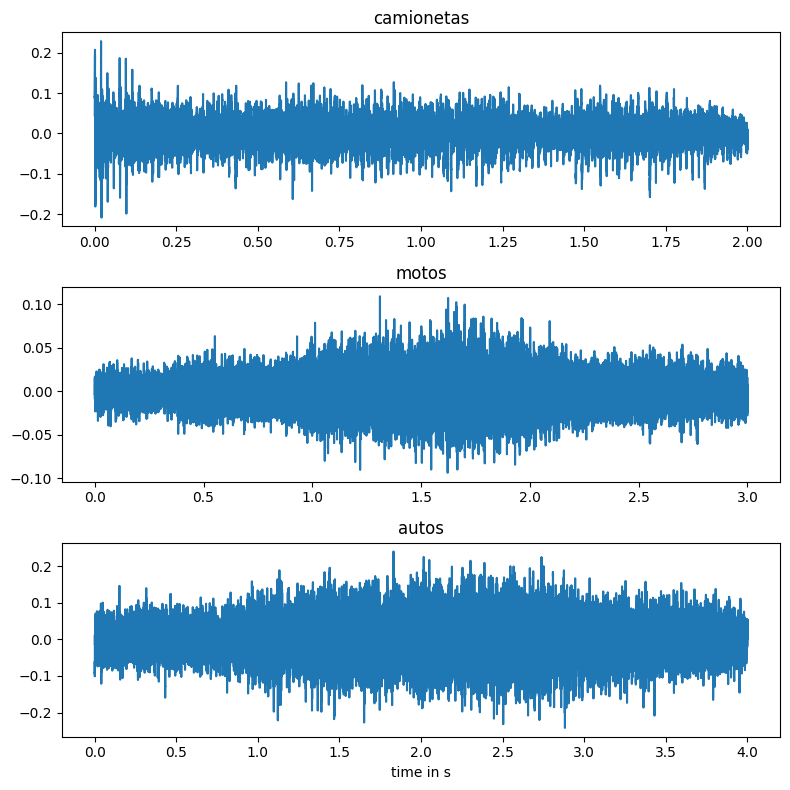

In [8]:
# dibujamos algun datito
rng = np.random.default_rng()
sr = 22050
keys = list(data.keys())
fig, axs = plt.subplots(3,1, figsize = (8,8))
for i in range(3):
    idx = rng.integers(len(data[keys[i]]))
    signal = data[keys[i]][idx]
    axs[i].set_title(keys[i])
    axs[i].plot(np.arange(len(signal))/sr, signal)
axs[i].set_xlabel(f'time in s')
fig.tight_layout()

In [9]:
def create_specs(x, ws, sr):
    '''Wrapper para calcular los espectrogramas de manera sencilla
    Regresa las frecuencias, los intervalos de tiempo y el espectrograma normalizado entre 0 y 1'''
    N = len(x)
    SFT = ShortTimeFFT(windows.boxcar(400), hop=400, fs=sr, scale_to='magnitude')
    ts = SFT.delta_t * np.arange(N)/ws #crea los timestamps
    Sx = SFT.spectrogram(x)  # perform the STFT
    Sx_l = np.log(Sx[:])
    Sx = (Sx_l - Sx_l.min())
    Sx /= Sx.max()

    return SFT.f, ts[::ws], Sx

In [10]:
# para hacer un entrenamiento vamos a utilizar como features los espectrogramas
ws = 220            # Ancho de la ventana temporal
spects = {}         # creamos listas vacías
for k in data.keys():
    spects[k] = spects.get(k, [])

# llenamos las listas con espectrogramas
for k in data.keys():
    for d in data[k]:
        spec = create_specs(d, ws=400, sr = 22050)
        spects[k].append(spec)


In [11]:
for k in spects.keys():
    i=0
    plt.figure(figsize=(20,4))
    for s in spects[k]:
        i += 1
        plt.subplot(1, len(spects[k]), i)
        plt.imshow(s[2], origin='lower', extent=[s[1][0],s[1][-1],s[0][0], s[0][-1]], aspect='auto', interpolation=None)
        plt.colorbar()
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
print(spects['colectivos'][0][0])

[    0.       55.125   110.25    165.375   220.5     275.625   330.75
   385.875   441.      496.125   551.25    606.375   661.5     716.625
   771.75    826.875   882.      937.125   992.25   1047.375  1102.5
  1157.625  1212.75   1267.875  1323.     1378.125  1433.25   1488.375
  1543.5    1598.625  1653.75   1708.875  1764.     1819.125  1874.25
  1929.375  1984.5    2039.625  2094.75   2149.875  2205.     2260.125
  2315.25   2370.375  2425.5    2480.625  2535.75   2590.875  2646.
  2701.125  2756.25   2811.375  2866.5    2921.625  2976.75   3031.875
  3087.     3142.125  3197.25   3252.375  3307.5    3362.625  3417.75
  3472.875  3528.     3583.125  3638.25   3693.375  3748.5    3803.625
  3858.75   3913.875  3969.     4024.125  4079.25   4134.375  4189.5
  4244.625  4299.75   4354.875  4410.     4465.125  4520.25   4575.375
  4630.5    4685.625  4740.75   4795.875  4851.     4906.125  4961.25
  5016.375  5071.5    5126.625  5181.75   5236.875  5292.     5347.125
  5402.25   5457.

In [13]:
# poniendo todos los datos como una lista
train_x = []
labels = []
for k in spects.keys():
    for s in spects[k]:
        train_x.append(s[2])
        labels.append([k])

In [14]:
print(labels)

[['camionetas'], ['camionetas'], ['camionetas'], ['camionetas'], ['camionetas'], ['camionetas'], ['camionetas'], ['camionetas'], ['motos'], ['motos'], ['motos'], ['motos'], ['motos'], ['motos'], ['autos'], ['autos'], ['autos'], ['autos'], ['autos'], ['autos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos'], ['colectivos']]


#Codificar los tipos de clases
Lo haremos con el tipo _One-Hot encoding_

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# Creamos el encoder
enc = LabelEncoder()
# transformamos y tenemos nuestros ground truth
train_y = enc.fit_transform(labels).reshape(-1,1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
print(train_y)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]


# Modelo 1: Clasificador con LSTMs
Vamos a hacer un clasificador con LSTMs utilizando un espectrograma.

## Creación del modelo de LSTM
Este modelo recibe como input un espectro de 201 frecuencias (porque usamos una ventana de 400 datos). A su vez, dada la forma en que se realiza la FFT, tendremos sampleadas estas frecuencias de manera equiespaciadas cada unos 55 Hz (aproximadamente), desde 0 hasta 11025 Hz. Supondremos que esta discretización en frecuencias es adecuada.

Como tenemos series de datos sin un largo fijo, lo más adecuado es utilizar RNNs. Por otra parte esto nos permitirá pasar tramos de la serie para un aprendizaje más eficiente, incrementando el conjunto de entrenamiento.

In [77]:
class SimpleLSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size  = 201,  #ws=400/2 + 1
                                  hidden_size = 64,
                                  num_layers  = 5,
                                  batch_first = True,
                                  bidirectional= True)
        self.fcon = torch.nn.Linear( in_features  = 2* 64, #se multiplica por 2 por ser bidireccional
                                     out_features = 4)

    def forward(self, x):
        print(x.shape)
        x, _ = self.lstm(x)
        x = self.fcon(x)
        # x = torch.sigmoid(x)
        return x[:,-1,:].squeeze(1) # regresamos el ultimo valor (many to one)

In [88]:
model = SimpleLSTM().to(device)
# vamos a probar el modelo (pasamos los n primeros conjuntos de frecuencias del espectrograma)
n = 5
print(f'Shape del tensor de entrada: {torch.from_numpy(train_x[0][:,:n].reshape(1,n,201)).float().shape}')
print(f'tensor de salida: {model(torch.from_numpy(train_x[0][:,:n].reshape(1,n,201)).float().to(device))}')

Shape del tensor de entrada: torch.Size([1, 5, 201])
torch.Size([1, 5, 201])
tensor de salida: tensor([[-0.0505, -0.0751, -0.0046,  0.0550]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [20]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = torch.nn.CrossEntropyLoss()
hist = []

In [21]:
n_samples = train_x[1].shape[1]  #cantidad de tiempo
n_features = train_x[1].shape[0]
print(n_samples)
print(n_features)
print(torch.FloatTensor(train_x[1][:n_features,:]).view(1,n_samples, n_features))
print(torch.FloatTensor(train_x[1][:n_features,:]).view(1,n_samples, n_features).shape)

111
201
tensor([[[0.6090, 0.2805, 0.6675,  ..., 0.8028, 0.8685, 0.5968],
         [0.8040, 0.8152, 0.8818,  ..., 0.7843, 0.7651, 0.8130],
         [0.7383, 0.8748, 0.8501,  ..., 0.8762, 0.8004, 0.9281],
         ...,
         [0.4430, 0.4083, 0.3816,  ..., 0.3362, 0.3503, 0.3866],
         [0.3132, 0.3324, 0.4127,  ..., 0.4471, 0.4151, 0.4913],
         [0.5176, 0.1629, 0.4248,  ..., 0.5155, 0.5377, 0.4613]]])
torch.Size([1, 111, 201])


In [22]:
print(train_y[1])

[1]


42.35670447349548
42.01947104930878
41.94521629810333
41.885273814201355
41.83237147331238
41.78446710109711
41.740350008010864
41.699283719062805
41.660876870155334
41.62492084503174
41.59128952026367
41.55988001823425
41.53058648109436
41.503293633461
41.47788143157959
41.45423245429993
41.432233929634094
41.411774039268494
41.39274549484253
41.37504005432129
41.35855317115784
41.34317898750305
41.32881844043732
41.315370202064514
41.302857756614685
41.293203830718994
41.293753147125244
41.27897083759308
41.261117815971375
41.25118327140808
41.242369651794434
41.23554825782776
41.22782266139984
41.22135865688324
41.213757395744324
41.208603501319885
41.201929688453674
41.19619929790497
41.18884265422821
41.18568742275238
41.176148414611816
41.17741048336029
41.168659925460815
41.163633584976196
41.15620791912079
41.16601896286011
41.16111409664154
41.13468933105469
41.08249640464783
41.11113464832306


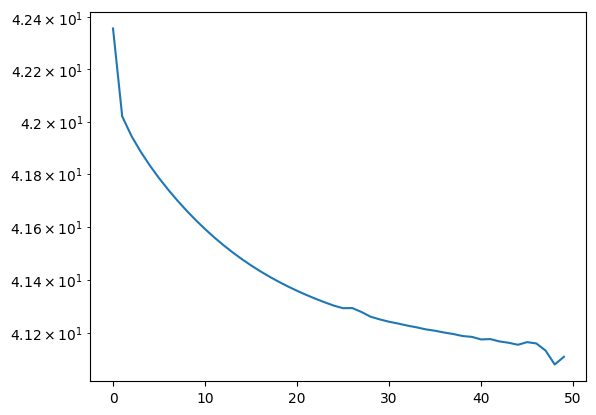

In [23]:
for e in range(50):
    cum = 0
    #train_x es un array de 11 elementos donde cada elemento es un par cuyo primer componenete son los 201 valores de frecuencia
    #y la segunda componente es el tiempo
    for i in range(len(train_x)):
        n_samples = train_x[i].shape[1]  #cantidad de muestras
        n_features = train_x[i].shape[0] #cantidad de puntos de frecuencia (201 para un ancho de frecuencia de 400)
        x = torch.FloatTensor(train_x[i][:n_features,:]).view(1,n_samples, n_features).to(device)
        y = torch.LongTensor(train_y[i]).to(device)
        y_pred = model(x)
        loss = criterion( y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cum += loss.item()
    print(cum)
    hist.append(cum)
plt.semilogy(hist)

In [24]:
idx = np.random.randint(20)
print(train_x[idx].shape)
pp = model(torch.from_numpy(train_x[idx].reshape(1,-1,201)).float().to(device)).detach().cpu().numpy()
print('pred',enc.inverse_transform(np.argmax(pp).reshape(1)))
print('true',enc.inverse_transform(train_y[idx].reshape(1)))


(201, 111)
pred ['colectivos']
true ['camionetas']


#Modelo 0: CNN sobre espectogramas del mismo largo.

Recortar los espectogramas a una misma lngitud tomando el centro de cada espectograma y recortando a izquiera y derecha proporcionalmente respecto a la menor longitud de audios

In [39]:
#obtener menor longiud para recortar espectogramas
men=train_x[0].shape[1]
for i in range (1,len(train_x)):
  if (train_x[i].shape[1]<men):
    men=train_x[i].shape[1]
print(men)

111


In [40]:
#ponemos todos los espectogramas con el mismo largo
train=[]
for i in range (len(train_x)):
  tam=train_x[i].shape[1]
  if (tam!=men):
    train.append(train_x[i][:,tam//2-men//2:tam//2+(men//2)+1])
  else:
    train.append(train_x[i])

In [41]:
for i in range (len(train)):
  print(train[i].shape)

(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)
(201, 111)


In [28]:
for k in spects.keys():
    plt.figure(figsize=(20,4))
    j=0
    for i in range(len(spects[k])):
        j+=1
        plt.subplot(1, len(spects[k]),j)
        plt.imshow(train[i], origin='lower', aspect='auto', interpolation=None) #extent=[s[1][0],s[1][-1],s[0][0], s[0][-1]],
        plt.colorbar()
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

##Modelo CNN
Recibe como parámteros el tamaño de los espectogramas para que se adapte a diferentes longitudes

In [42]:
# Definimos un modelo
class CNN(torch.nn.Module):
    def __init__(self, num_f,num_c):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=32,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)
                                     )
        self.drop = torch.nn.Dropout(0.25)
        # 16, 201*111
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 16, achica en 2 la dimensión
        self.conv2 = torch.nn.Conv2d(in_channels = 32,
                                     out_channels=64,
                                     kernel_size=(3,3),
                                     stride=(1,1),
                                     padding=(1,1)
                                     )
        # 32, misma dimesión despues de max pool
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 32, achica en 2 la dimensión
        self.lin   = torch.nn.Linear(in_features = 64*(num_f//4)*(num_c//4),
                                     out_features = 4)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(0)
        x = self.lin(x)
        return x

In [43]:
#Como todos loes espectogramas tienen la misma dimensión, tomamos las
#dimensiones del primero para crear el modelo
num_f=train[0].shape[0]
num_c=train[0].shape[1]
cnn_model = CNN(num_f,num_c).to(device)

Probar que el modelo no tenga errores de definición

In [31]:
torch.from_numpy(train_x[0].reshape(1,num_f,num_c)).shape

torch.Size([1, 201, 111])

In [44]:
pred=cnn_model(torch.from_numpy(train[12].reshape(1,num_f,num_c)).float().to(device))

In [45]:
print(pred)

tensor([-0.1666,  0.1759, -0.0678,  0.2276], device='cuda:0',
       grad_fn=<ViewBackward0>)


Entrenamiento

In [46]:
# Loss function y optimizador
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cnn_model.parameters(), lr = 0.0001)
hist = []

153.34272477411832
96.17090499401093
44.9699672460556
43.78142201900482
43.38189423084259
42.71214938163757
42.190672159194946
41.863003730773926
41.68413686752319
41.73959231376648
41.48675513267517
41.347625374794006
41.48008108139038
41.47606003284454
41.233762979507446
41.000856757164
41.071598172187805
41.38898766040802
41.24416160583496
40.57412552833557
40.880494236946106
40.71452820301056
39.98749387264252
40.3625807762146
39.60087966918945
39.26993978023529
39.04460787773132
38.500181555747986
38.24626803398132
37.617567002773285
36.81341356039047
36.466785311698914
35.277280390262604
35.23674035072327
34.1776584982872
33.045298874378204
32.56369936466217
31.245497703552246
30.14748901128769
30.199113309383392
28.693722665309906
27.93441939353943
27.334194868803024
26.4129056930542
24.73591321706772
23.447657495737076
23.328498482704163
21.447523146867752
20.98953564465046
19.645317927002907
19.047995552420616
16.744174271821976
16.58181957155466
14.748492769896984
13.96973047

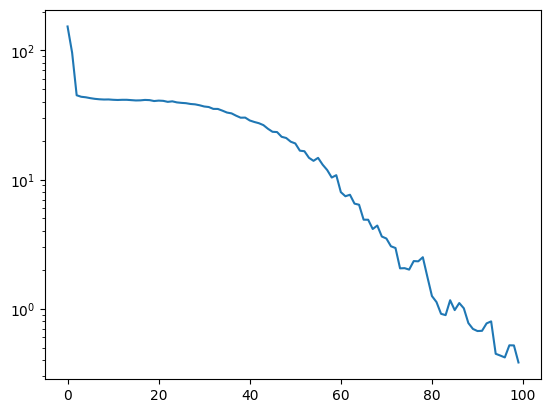

In [47]:
for epochs in range(100):
  cum = 0
  for i in range(len(train)):
    x=torch.unsqueeze(torch.from_numpy(train[i]).float(),0).to(device)
    y=torch.LongTensor(train_y[i]).to(device)
    ypred = cnn_model(x)
    loss = criterion(torch.unsqueeze(ypred,0), y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    cum += loss.item()
  print(cum)
  hist.append(cum)
plt.semilogy(hist)

In [55]:
idx = np.random.randint(len(train))
x=torch.unsqueeze(torch.from_numpy(train[idx]).float(),0).to(device)
ypred = cnn_model(x).detach().cpu().numpy()
print('pred',enc.inverse_transform(np.argmax(ypred).reshape(1)))
print('true',enc.inverse_transform(train_y[idx].reshape(1)))

pred ['motos']
true ['motos']


#Modelo Combinado: CNN + LSTM

1. Preparar Datos

In [56]:
#obtener menor longiud para recortar espectogramas
men=train_x[0].shape[1]
for i in range (1,len(train_x)):
  if (train_x[i].shape[1]<men):
    men=train_x[i].shape[1]
print(men)

111


In [57]:
#ponemos todos los espectogramas con el mismo largo
train=[]
for i in range (len(train_x)):
  tam=train_x[i].shape[1]
  if (tam!=men):
    train.append(train_x[i][:,tam//2-men//2:tam//2+(men//2)+1])
  else:
    train.append(train_x[i])

In [58]:
#Printear los espectogramas
for k in spects.keys():
    plt.figure(figsize=(20,4))
    j=0
    for i in range(len(spects[k])):
        j+=1
        plt.subplot(1, len(spects[k]),j)
        plt.imshow(train[i], origin='lower', aspect='auto', interpolation=None) #extent=[s[1][0],s[1][-1],s[0][0], s[0][-1]],
        plt.colorbar()
    plt.suptitle(k)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

2. Definir el Modelo Combinado

In [101]:
# Definimos un modelo
class CNN_LSTM(torch.nn.Module):
    def __init__(self, num_f,num_c):
        super().__init__()
        #********CNN********#
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=32,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)
                                     )
        self.drop = torch.nn.Dropout(0.25)
        # 32, 201*111
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 32, achica en 2 la dimensión
        self.conv2 = torch.nn.Conv2d(in_channels = 32,
                                     out_channels=64,
                                     kernel_size=(3,3),
                                     stride=(1,1),
                                     padding=(1,1)
                                     )
        # 64, misma dimesión despues de max pool
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2))
        #64, achica en 2 la dimensión
        self.lin   = torch.nn.Linear(in_features = 64*(num_f//4)*(num_c//4),
                                     out_features = 32)
        #********LSTM********#
        self.lstm = torch.nn.LSTM(input_size  = 32,
                                  hidden_size = 64,
                                  num_layers  = 5,
                                  batch_first = True,
                                  bidirectional= True)
        self.fcon = torch.nn.Linear( in_features  = 2* 64, #se multiplica por 2 por ser bidireccional
                                     out_features = 4)


    def forward(self, x):
        #********CNN********#
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(0)
        x = self.lin(x)
        #********LSTM********#
        x= x[None,None,:]
        x, _ = self.lstm(x)
        x = self.fcon(x)
        return x[:,-1,:].squeeze(1) # regresamos el ultimo valor (many to one)

In [102]:
#Como todos loes espectogramas tienen la misma dimensión, tomamos las
#dimensiones del primero para crear el modelo
num_f=train[0].shape[0]
num_c=train[0].shape[1]
cmodel = CNN_LSTM(num_f,num_c).to(device)

3. Probar que el modelo no tenga errores de definición

In [103]:
pred=cmodel(torch.from_numpy(train[12].reshape(1,num_f,num_c)).float().to(device))

In [104]:
print(pred)

tensor([[ 0.0021,  0.0346, -0.0675, -0.0558]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


4. Entrenar Modelo

In [110]:
# Loss function y optimizador
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cmodel.parameters(), lr = 0.0001)
hist = []

41.310778975486755
41.19175088405609
41.17898428440094
41.16909980773926
41.15987026691437
41.15119004249573
41.143072962760925
41.13544952869415
41.128342628479004
41.12174928188324
41.11564230918884
41.1099978685379
41.104780197143555
41.09996247291565
41.09551680088043
41.09141135215759
41.08762085437775
41.08411741256714
41.080873012542725
41.077847838401794
41.075037121772766
41.072412848472595
41.06996536254883
41.06766426563263
41.065491914749146
41.06341898441315
41.06146228313446
41.059608578681946
41.057838559150696
41.05615198612213
41.0545312166214
41.05297672748566
41.05148231983185
41.050053000450134
41.048681139945984
41.04734909534454
41.046043276786804
41.04476070404053
41.04352259635925
41.042330622673035
41.04116880893707
41.04004430770874
41.03894555568695
41.0378794670105
41.036837339401245
41.035831689834595
41.03484869003296
41.03389847278595
41.03295683860779
41.032047510147095
41.031147599220276
41.03026354312897
41.02939224243164
41.02854645252228
41.027717590

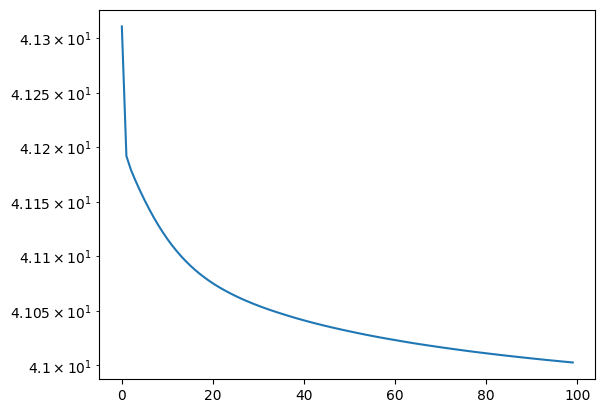

In [111]:
for epochs in range(100):
  cum = 0
  for i in range(len(train)):
    x=torch.unsqueeze(torch.from_numpy(train[i]).float(),0).to(device)
    y=torch.LongTensor(train_y[i]).to(device)
    ypred = cmodel(x)
    loss = criterion(ypred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    cum += loss.item()
  print(cum)
  hist.append(cum)
plt.semilogy(hist)